In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf

In [2]:
len(os.listdir('./image/'))

30000

In [3]:
import matplotlib.pyplot as plt

In [4]:
sample = cv2.imread('./image/180.jpg')

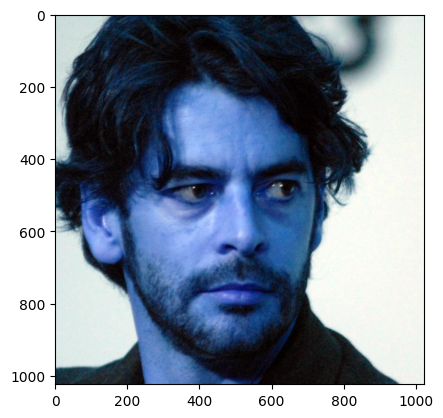

In [5]:
plt.imshow(sample)

In [6]:
sample.shape

(1024, 1024, 3)

In [7]:
!ls

CelebA-HQ-to-CelebA-mapping.txt  glove.840B.300d.txt
ForensicAI-Text-to-FaceGAN.ipynb image
Papers                           text
captions_hq.json


# Data Loader

In [8]:
import tensorflow
import math

In [9]:
Y_train = []
        
for i in range(30000):
    description = ''

    with open('./text'+'/'+str(i)+'.txt') as f:
        contents = f.read()
        description += contents

    description = description.replace("\n", "")

    Y_train.append(description)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
t = Tokenizer()

In [12]:
t.fit_on_texts(Y_train)
embed = t.texts_to_sequences(Y_train)

In [13]:
print(embed[0])

[10, 7, 2, 20, 21, 1, 31, 12, 4, 3, 13, 16, 4, 3, 13, 16, 4, 3, 9, 1, 27, 1, 2, 8, 29, 17, 18, 19, 31, 12, 1, 20, 21, 6, 23, 22, 2, 20, 21, 31, 12, 41, 15, 17, 18, 19, 30, 5, 28, 15, 1, 32, 33, 24, 6, 22, 3, 23, 1, 2, 41, 15, 17, 18, 19, 31, 12, 1, 32, 33, 24, 4, 14, 16, 4, 3, 27, 1, 9, 1, 2, 8, 29, 31, 12, 20, 21, 28, 15, 30, 5, 1, 17, 18, 19, 10, 7, 2, 8, 29, 30, 5, 28, 15, 20, 21, 32, 33, 24, 36, 5, 17, 18, 19, 1, 31, 12, 4, 3, 13, 25, 26, 6, 22, 2, 17, 18, 19, 4, 3, 23, 1, 9, 1, 3, 13, 25, 26, 4, 2, 28, 15, 8, 29, 32, 33, 24, 31, 12, 1, 17, 18, 19, 4, 3, 13, 16, 4, 3, 9, 1, 23, 4, 3, 27, 1, 2, 20, 21, 4, 3, 23, 1, 2, 41, 15, 36, 5, 17, 18, 19, 20, 21, 31, 12, 1, 28, 15]


In [14]:
from tensorflow.keras.utils import pad_sequences

In [15]:
pad_embed = pad_sequences(embed,maxlen=300)

In [16]:
vocab_size = len(t.word_index)+1

In [17]:
vocab_size

65

In [18]:
t.word_counts

OrderedDict([('the', 100167),
             ('person', 107369),
             ('has', 315982),
             ('high', 69319),
             ('cheekbones', 69319),
             ('and', 376162),
             ('pointy', 47776),
             ('nose', 96672),
             ('she', 254565),
             ('is', 278334),
             ('wearing', 88584),
             ('lipstick', 78129),
             ('young', 100944),
             ('smiling', 57828),
             ('big', 103727),
             ('lips', 54831),
             ('mouth', 71262),
             ('slightly', 71262),
             ('open', 71262),
             ('this', 114913),
             ('attractive', 64448),
             ('woman', 65068),
             ('bushy', 28584),
             ('eyebrows', 83857),
             ('wavy', 53667),
             ('hair', 186960),
             ('arched', 55273),
             ('bags', 43413),
             ('under', 43413),
             ('eyes', 61094),
             ('wears', 88366),
             ('brown', 35

In [19]:
pad_embed.shape

(30000, 300)

In [20]:
embedding_vector = {}
f = open('glove.840B.300d.txt')
for line in f:
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

In [21]:
embedding_matrix = np.zeros((vocab_size,300))
for word,i in t.word_index.items():
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

In [22]:
embedding_matrix.shape

(65, 300)

In [23]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, batch_size, image_path, text_path):
        self.batch_size = batch_size
        self.image_path = image_path
        self.text_path = text_path
        self.current_index = 0
        
        
    def __len__(self):
        total_size = len(os.listdir(self.image_path))
        return math.ceil(total_size / self.batch_size)
        
    
    def __getitem__(self, idx):
        # [idx, idx + batch_size]
        # 5 ---> 24 * 4 = 96 --> [97,97+23] --> [97,120] --> 6 ---> 24 * 5 = 120 ---> [121,121+23]
        # idx ---> batch_size * (idx - 1) --> [(batch_size * (idx - 1))+1,((batch_size * (idx - 1))+1)+batch_size-1]
        # idx++
        
        low = (self.batch_size * (idx-1))
        high = low + (self.batch_size-1)
        
        batch_x = []
        batch_y = []
        
        for i in range(low,high+1,1):
            img = cv2.imread(self.image_path+'/'+str(i)+'.jpg')
            img = cv2.resize(img,(64,64))
            batch_x.append(img)
            
            description = ''
            
            with open(self.text_path+'/'+str(i)+'.txt') as f:
                contents = f.read()
                description += contents
                
            description = description.replace("\n", "")
            
            #batch_y.append(description)
            batch_y.append(pad_embed[i])
            
        return np.array(batch_x),np.array(batch_y)    
    


In [24]:
data_generator = DataGenerator(24,'./image', './text')

In [25]:
sample_x,sample_y = data_generator.__getitem__(1250)

In [26]:
sample_x.shape

(24, 64, 64, 3)

In [27]:
sample_y.shape

(24, 300)

# Pre-processing

# Model Stage 1 GAN

In [28]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
import tensorflow.keras.backend as K

In [29]:
def generate_noise(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]

    stddev = tf.math.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
    
    c = mean + stddev * epsilon
    return c

def build_ca_model():
    
    input_layer = Input(shape=(300,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

In [30]:
#y = ax + b

def build_generator_stage1():
    #x = Embedding(vocab_size,32,input_length=300,weights=[embedding_matrix],trainable=False)
    #x = Flatten()(x)
    
    input_layer = Input(shape=(300,))
    x = Dense(256)(input_layer)
    act1 = LeakyReLU(0.2)(x)
    
    conditional_a = Lambda(generate_noise)(act1)
    input_layer2 = Input(shape=(100,))
    
    generator_input = Concatenate(axis=1)([conditional_a,input_layer2])
    
    x = Dense(128*8*4*4,use_bias=False)(generator_input)
    x = ReLU()(x)
    
    x = Reshape((4,4,128*8))(x)
    
    #4,4,1024 --> 8,8,512 --> 16,16,256 --> 32,32,128 --> 64,64,64 --> #Block Ends --> 64,64,3
    # RGB 
    
    
    #Block 1
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(512,kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    #Block 2
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(256,kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    #Block 3
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(128,kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    #Block 4
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(64,kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(3,kernel_size=3,padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)
    
    generator = Model(inputs=[input_layer,input_layer2], outputs=[x,act1])
    
    return generator
    

In [31]:
def build_discriminator_stage1():
    
    input_image = Input(shape=(64,64,3))
    
    x = Conv2D(64, kernel_size=4, padding='same', strides=2, use_bias=False)(input_image)
    x = LeakyReLU(alpha=0.2)(x)
    
    #Block 1
    x = Conv2D(128, kernel_size=4, padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #Block 2
    x = Conv2D(256, kernel_size=4, padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    #Block 3
    x = Conv2D(512, kernel_size=4, padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    input_text = Input(shape=(4, 4, 128))
    
    merged = concatenate([x,input_text])
    
    x2 = Conv2D(512, kernel_size=1, padding='same', strides=1, use_bias=False)(merged)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    
    x2 = Flatten()(x2)
    x2 = Dense(1)(x2)
    x2 = Activation('sigmoid')(x2)
    
    model = Model(inputs=[input_image,input_text],outputs=[x2])
    
    return model

In [32]:
def build_embedding_compressor():

    input_layer1 = Input(shape=(300,)) 
    x = Dense(128)(input_layer1)
    x = ReLU()(x)

    model = Model(inputs=[input_layer1], outputs=[x])
    return model

In [33]:
def build_gan(generator,discriminator):
    
    input_layer1 = Input(shape=(300,)) #Embeddings
    input_layer2 = Input(shape=(100,)) #Noise
    input_layer3 = Input(shape=(4,4,128)) #Embeddings_ca
    
    gen_img,embed_ca = generator([input_layer1,input_layer2])
    
    discriminator.trainable = False
    pred = discriminator([gen_img, input_layer3])
    
    model = Model(inputs=[input_layer1,input_layer2,input_layer3], outputs=[embed_ca,pred])
    
    return model

In [34]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    ls = y_pred[:, 128:]
    loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
    loss = K.mean(loss)
    return loss

In [35]:
## Stage 1 Training

ca_model = build_ca_model()
ca_model.compile(loss="binary_crossentropy",optimizer="adam")

stage1_generator = build_generator_stage1()
stage1_generator.compile(loss="mse", optimizer="adam")

stage1_discriminator = build_discriminator_stage1()
stage1_discriminator.compile(loss="binary_crossentropy", optimizer="adam")

embedding_compressor = build_embedding_compressor()
embedding_compressor.compile(loss="binary_crossentropy", optimizer="adam")

stage1_gan = build_gan(stage1_generator,stage1_discriminator)
stage1_gan.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0], optimizer="adam")

Metal device set to: Apple M1


2022-10-11 23:09:59.896980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-11 23:09:59.897142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
def stage1_training(epochs,batch_size):
    
    z_dim = 100
    real = np.ones((batch_size, 1), dtype='float') * 0.9
    fake = np.zeros((batch_size, 1), dtype='float') * 0.1
    
    
    for epoch in range(epochs):
        print("==========================================")
        print("Current Epoch: ",epoch+1)
        
        gan_loss = []
        dis_loss = []
        
        len_epochs = data_generator.__len__()
        
        #Load->Pass to Generator->Disriminator (Real+Fake+Wrong)->
        
        for i in range(len_epochs):
            print("Current Batch is: ",i+1)
            
            batch_X,batch_Y = data_generator.__getitem__(i+batch_size)
            
            
            z_noise = np.random.normal(0,1,size=(batch_size,z_dim))
            normalized_X = (batch_X - 127.5) / 127.5  # Pixel Range -1 to 1
            
            #Pass to generator
            gen_images, _ = stage1_generator.predict([batch_Y,z_noise])
            
            compressed_embedding = embedding_compressor.predict_on_batch(batch_Y)
            compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
            compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
            
            
            dis_loss_real = stage1_discriminator.train_on_batch([normalized_X,compressed_embedding],np.reshape(real, (batch_size, 1)))
            dis_loss_fake = stage1_discriminator.train_on_batch([gen_images,compressed_embedding],np.reshape(fake, (batch_size, 1)))
            dis_loss_wrong = stage1_discriminator.train_on_batch([normalized_X[:(batch_size - 1)], compressed_embedding[1:]],
                                                       np.reshape(fake[1:], (batch_size-1, 1)))
            
            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_fake, dis_loss_wrong))
            
            dis_loss.append(d_loss)
            print('Discriminator Loss: {}'.format(d_loss))
            
            gan_loss = stage1_gan.train_on_batch([batch_Y,z_noise,compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])
            gan_loss.append(gan_loss)
            
            print('GAN Loss: {}'.format(gan_loss))

In [37]:
stage1_discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 64)   3072        ['input_4[0][0]']                
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 128)  131072      ['leaky_re_lu_2[0][0]']          
                                                                                            

In [ ]:
stage1_training(10,24)

Current Epoch:  1
Current Batch is:  1


2022-10-11 23:10:28.602747: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-11 23:10:28.670626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 246ms/step


2022-10-11 23:10:28.884846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-11 23:10:29.240331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-11 23:10:29.677225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Discriminator Loss: 3.50187087059021


2022-10-11 23:10:30.343615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


GAN Loss: [7.787353515625, 7.787353515625, 0.0, [...]]
Current Batch is:  2
1/1 [==============================] - 0s 72ms/step
Discriminator Loss: 0.5155003741383553
GAN Loss: [7.542199611663818, 7.542199611663818, 0.0, [...]]
Current Batch is:  3
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 1.7396786669269204
GAN Loss: [7.150994777679443, 7.150994777679443, 0.0, [...]]
Current Batch is:  4
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 1.6561583406291902
GAN Loss: [6.872531414031982, 6.872531414031982, 0.0, [...]]
Current Batch is:  5
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 1.053749967366457
GAN Loss: [6.641571044921875, 6.641571044921875, 0.0, [...]]
Current Batch is:  6
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.7402073368430138
GAN Loss: [6.311309814453125, 6.311309814453125, 0.0, [...]]
Current Batch is:  7
1/1 [==============================] - 0s 66ms/step
Discrimi

1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.6321753971278667
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  50
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.6311150102410465
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  51
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.6141427041729912
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  52
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5634718592627905
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  53
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5935024011414498
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  54
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.6016584804747254
GAN Loss: [1.5249241590499878

1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.6080851282167714
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  97
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.59707666921895
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  98
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5810146374860778
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  99
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5960873679723591
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  100
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.6049763850751333
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  101
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 0.5728812111192383
GAN Loss: [1.5249241590499878

GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  143
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.575462420238182
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  144
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.5696356086409651
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  145
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 0.5583508362469729
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  146
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5761594333889661
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  147
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5829861195525154
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  148
1/1 [=========================

1/1 [==============================] - 0s 67ms/step
Discriminator Loss: 0.5711422636522911
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  190
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5692098103172611
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  191
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5849649302545004
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  192
1/1 [==============================] - 0s 67ms/step
Discriminator Loss: 0.6103685043635778
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  193
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.5985085271968273
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  194
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.5995450189220719
GAN Loss: [1.52492415904

GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  236
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5984670754696708
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  237
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.6053819981607376
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  238
1/1 [==============================] - 0s 65ms/step
Discriminator Loss: 0.5562854323288775
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  239
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5610571272845846
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  240
1/1 [==============================] - 0s 65ms/step
Discriminator Loss: 0.5601271474006353
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  241
1/1 [========================

1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.5804733882396249
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  283
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5626063134986907
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  284
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.5810845004743896
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  285
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5902259765862254
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  286
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.5599923568079248
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  287
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5604332197399344
GAN Loss: [1.52492415904

GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  329
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.5904180670622736
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  330
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5443021040846361
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  331
1/1 [==============================] - 0s 59ms/step
Discriminator Loss: 0.5528983531403355
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  332
1/1 [==============================] - 0s 59ms/step
Discriminator Loss: 0.6000410382985137
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  333
1/1 [==============================] - 0s 69ms/step
Discriminator Loss: 0.5693167023709975
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  334
1/1 [========================

1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5934357661171816
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  376
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5600229796837084
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  377
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5692723579704762
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  378
1/1 [==============================] - 0s 59ms/step
Discriminator Loss: 0.6410795217889245
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  379
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5367490861972328
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  380
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.6218057563528419
GAN Loss: [1.52492415904

GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  422
1/1 [==============================] - 0s 72ms/step
Discriminator Loss: 0.5359819263685495
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  423
1/1 [==============================] - 0s 65ms/step
Discriminator Loss: 0.5462815389619209
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  424
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5715215421514586
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  425
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5184560521738604
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  426
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 0.6068401768570766
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  427
1/1 [========================

1/1 [==============================] - 0s 59ms/step
Discriminator Loss: 0.5522510250448249
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  469
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 0.5370170904207043
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  470
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.4805705966427922
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  471
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5553198364796117
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  472
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.5887476519565098
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  473
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.6049105660495115
GAN Loss: [1.52492415904

Discriminator Loss: 0.5188183923019096
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  515
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.555001533444738
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  516
1/1 [==============================] - 0s 60ms/step
Discriminator Loss: 0.5767753154505044
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  517
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5108651316841133
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  518
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.5769363402796444
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  519
1/1 [==============================] - 0s 59ms/step
Discriminator Loss: 0.5493359174579382
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch 

1/1 [==============================] - 0s 68ms/step
Discriminator Loss: 0.5083171650476288
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  562
1/1 [==============================] - 0s 71ms/step
Discriminator Loss: 0.5358115259296028
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  563
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5045339775970206
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  564
1/1 [==============================] - 0s 65ms/step
Discriminator Loss: 0.5838705091446172
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  565
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.6778454155282816
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  566
1/1 [==============================] - 0s 64ms/step
Discriminator Loss: 0.5632307354244404
GAN Loss: [1.52492415904

GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  608
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5966043719963636
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  609
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.522104352407041
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  610
1/1 [==============================] - 0s 65ms/step
Discriminator Loss: 0.5835882707033306
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  611
1/1 [==============================] - 0s 57ms/step
Discriminator Loss: 0.5375116149371024
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  612
1/1 [==============================] - 0s 58ms/step
Discriminator Loss: 0.528744584589731
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  613
1/1 [==========================

1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.4881288739852607
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  655
1/1 [==============================] - 0s 72ms/step
Discriminator Loss: 0.5794987124827458
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  656
1/1 [==============================] - 0s 63ms/step
Discriminator Loss: 0.5488239624828566
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  657
1/1 [==============================] - 0s 62ms/step
Discriminator Loss: 0.5428829412412597
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  658
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5332151544971566
GAN Loss: [1.5249241590499878, 1.5249241590499878, 0.0, [...]]
Current Batch is:  659
1/1 [==============================] - 0s 61ms/step
Discriminator Loss: 0.5153960227908101
GAN Loss: [1.52492415904